# M5 Forecasting - Accuracy

This kernel is:
- Feature engineering based on [Very fst Model](https://www.kaggle.com/ragnar123/very-fst-model). Thanks [@ragnar123](https://www.kaggle.com/ragnar123).
- Experimented with Random Forest, Deep neural network - fully connected, RNN for same dataset 

# Objective

* Make a baseline model that predict the validation (28 days).
* This competition has 2 stages, so the main objective is to make a model that can predict the demand for the next 28 days.

This competition uses a Weighted Root Mean Squared Scaled Error (RMSSE) for evaluation

In [1]:
import gc
import os
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from fastai import *
from fastai.tabular import *
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [2]:
from imports import *
from structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [3]:
import IPython


def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
def read_data():
    INPUT_DIR = "/home/shanmugam/fastai/m5"

    print("Reading files...")

    calendar = pd.read_csv(f"{INPUT_DIR}/calendar.csv").pipe(reduce_mem_usage)
    sell_prices = pd.read_csv(f"{INPUT_DIR}/sell_prices.csv").pipe(reduce_mem_usage)

    # Limit the number of columns to use to prevent OOM error.
    sales_train_val = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv",).pipe(
        reduce_mem_usage
    )
    submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
        reduce_mem_usage
    )

    print("Calendar shape:", calendar.shape)
    print("Sell prices shape:", sell_prices.shape)
    print("Sales train shape:", sales_train_val.shape)
    print("Submission shape:", submission.shape)

    return calendar, sell_prices, sales_train_val, submission

In [4]:
calendar, sell_prices, sales_train_val, submission = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)
Calendar shape: (1969, 14)
Sell prices shape: (6841121, 4)
Sales train shape: (30490, 1919)
Submission shape: (60980, 29)


As [@kaushal2896](https://www.kaggle.com/kaushal2896) suggested in [this comment](https://www.kaggle.com/harupy/m5-baseline#770558), encode the categorical columns before merging to prevent the notebook from crashing even with the full dataset.

In [7]:
def encode_categorical(df, cols, fillna=False):
    for col in cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(
            df[col].fillna("MISSING") if fillna else df[col]
        )
    return df


calendar = encode_categorical(
    calendar,
    ["event_name_1", "event_type_1", "event_name_2", "event_type_2"],
    fillna=True,
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.07 Mb (43.0% reduction)
Mem. usage decreased to 94.01 Mb (1.0% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [8]:
def melt(
    sales_train_val, submission, nrows=55_000_000, verbose=True,
):
    # melt sales data, get it ready for training
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    sales_train_val = pd.melt(
        sales_train_val, id_vars=id_columns, var_name="day", value_name="demand",
    )

    sales_train_val = reduce_mem_usage(sales_train_val)

    if verbose:
        print("After melt")
        display(sales_train_val)

    # separate test dataframes.
    test1 = submission[submission["id"].str.endswith("validation")]
    test2 = submission[submission["id"].str.endswith("evaluation")]

    # change column names.
    test1.columns = ["id"] + [f"d_{x}".format(x) for x in range(1914, 1914 + 28)]
    test2.columns = ["id"] + [f"d_{x}".format(x) for x in range(1942, 1942 + 28)]

    # get product table.
    product = sales_train_val[id_columns].drop_duplicates()

    # merge with product table
    test2["id"] = test2["id"].str.replace("_evaluation", "_validation")
    test1 = test1.merge(product, how="left", on="id")
    test2 = test2.merge(product, how="left", on="id")
    test2["id"] = test2["id"].str.replace("_validation", "_evaluation")

    if verbose:
        print("test1 & 2")
        display(test1, test2)

    test1 = pd.melt(test1, id_vars=id_columns, var_name="day", value_name="demand")
    test2 = pd.melt(test2, id_vars=id_columns, var_name="day", value_name="demand")

    sales_train_val["part"] = "train"
    test1["part"] = "test1"
    test2["part"] = "test2"
    
    
    data = pd.concat([sales_train_val, test1, test2], axis=0)

    del sales_train_val, test1, test2

    # get only a sample for fast training.
#     data = data.loc[nrows:]

    # delete test2 for now.
    data = data[data["part"] != "test2"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar, verbose=True):
    # drop some calendar features.
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)

    # notebook crashes with the entire dataset.
    data = pd.merge(data, calendar, how="left", left_on=["day"], right_on=["d"])
    data = data.drop(["d", "day"], axis=1)
    
    data1 = data[(data['date'] > '2016-03-27')]
    data = data.drop(data.index[(list(range(57473650,59181090)))])
    data = data[data.demand != 0]
    data = pd.concat([data, data1], axis=0)
    del data1
    if verbose:
        print("with calendar merged")
        display(data)

    return data


def merge_sell_prices(data, sell_prices, verbose=True):
    # get the sell price data (this feature should be very important).
    data = data.merge(sell_prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")

    if verbose:
        print("with sell_prices merged")
        display(data)

    return data

In [9]:
data = melt(sales_train_val, submission, nrows=10_100_000)
del sales_train_val
gc.collect()

data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_sell_prices(data, sell_prices)
del sell_prices
gc.collect()

data = reduce_mem_usage(data)

Mem. usage decreased to 1335.01 Mb (0.0% reduction)
After melt


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0


test1 & 2


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1441,3,1,0,0


data


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0,train
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0,train
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0,train
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0,train
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0,train


with calendar merged


,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
7,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,12,train,2011-01-29,11101,13,1,3,1,0,0,0
8,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0
14,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,4,train,2011-01-29,11101,13,1,3,1,0,0,0
15,HOBBIES_1_016_CA_1_validation,1452,3,1,0,0,5,train,2011-01-29,11101,13,1,3,1,0,0,0
21,HOBBIES_1_022_CA_1_validation,1458,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0


with sell_prices merged


,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,12,train,2011-01-29,11101,13,1,3,1,0,0,0,0.459961
1,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0,1.559570
2,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,4,train,2011-01-29,11101,13,1,3,1,0,0,0,0.700195
3,HOBBIES_1_016_CA_1_validation,1452,3,1,0,0,5,train,2011-01-29,11101,13,1,3,1,0,0,0,0.700195
4,HOBBIES_1_022_CA_1_validation,1458,3,1,0,0,2,train,2011-01-29,11101,13,1,3,1,0,0,0,6.859375


Mem. usage decreased to 967.13 Mb (0.0% reduction)


In [ ]:
def add_agg_features(df):
    # rolling demand features.
    for shift in [28, 29, 30]:
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )

    for size in [7, 30]:
        df[f"rolling_std_t{size}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(28).rolling(size).std()
        )
    df = reduce_mem_usage(df)
    gc.collect()
    for size in [7, 30, 90, 180]:
        df[f"rolling_mean_t{size}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(28).rolling(size).mean()
        )

    df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(28).rolling(30).skew()
    )
    df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(28).rolling(30).kurt()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    # price features
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(30).std()
    )
    df = reduce_mem_usage(df)
    gc.collect()
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = ["year", "month", "week", "day", "dayofweek"]
    for attr in attrs:
        df[attr] = getattr(df[dt_col], attr)

    df["is_weekend"] = df["dayofweek"].isin([5, 6])
    return df

In [ ]:
data = add_agg_features(data)

In [ ]:
data = reduce_mem_usage(data)

In [15]:
data["is_weekend"] = data["Dayofweek"].isin([5, 6])
data = reduce_mem_usage(data)
gc.collect()

Mem. usage decreased to 1327.43 Mb (0.0% reduction)


20

# Random Forest

In [7]:
## categoricals
icols = ['store_id','state_id','item_id','dept_id','event_name_1','event_type_1', 'year',
       'month', 'week', 'day', 'dayofweek', 'is_weekend',]
for col in icols:
    data[col] = data[col].astype('category')

## label encoding 
icols = ['cat_id','event_name_2','event_type_2']
for col in icols:
    l_enc = LabelEncoder()
    data[col] = data[col].fillna('Unknown_data')

    l_enc.fit(data[col].values)
    data[col] = l_enc.transform(data[col])

In [8]:
df, y, nas = proc_df(data, 'demand', ignore_flds=['date', 'id', 'part'])
df['demand'] = y

In [9]:
df = reduce_mem_usage(df)
del data
gc.collect()

Mem. usage decreased to 1098.43 Mb (30.4% reduction)


27

In [105]:
test_df = df.iloc[9256764:].copy()
df.drop(['date', 'id', 'part'], axis=1, inplace=True)
df = reduce_mem_usage(df)
train_df = df.iloc[:8915276].copy()
valid_df = df.iloc[8915276:9256764].copy()
Y_train = y[:8915276]
Y_valid = y[8915276:9256764]
del df

# test_df = df.iloc[6942573:].copy()
# df.drop(['date', 'id', 'part'], axis=1, inplace=True)
# df = reduce_mem_usage(df)
# train_df = df.iloc[:6686457].copy()
# valid_df = df.iloc[6686457:6942573].copy()
# Y_train = y[:6686457]
# Y_valid = y[6686457:6942573]
# del df
# max_log_y = np.log(np.max(train_df['demand']))
# del train_df
# y_range = torch.tensor([0, max_log_y*1.2])
# y_range

Mem. usage decreased to 549.22 Mb (0.0% reduction)


In [106]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(train_df), Y_train), rmse(m.predict(valid_df), Y_valid),
                m.score(train_df, Y_train), m.score(valid_df, Y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [107]:
set_rf_samples(20000)

In [108]:
m = RandomForestRegressor(n_estimators=115, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True )
m.fit(train_df, Y_train)
print_score(m)

[0. 0. 0. 2. ... 0. 0. 2. 0.]
[0.43884 0.13884 0.43928 2.10877 ... 0.30029 0.66406 1.87982 0.64609]
[0. 0. 0. 2. ... 0. 0. 2. 0.]
[0.43884 0.13884 0.43928 2.10565 ... 0.30029 0.66406 1.88377 0.64609]
[0. 0. 0. 2. ... 0. 0. 2. 0.]
[0.43884 0.13884 0.43928 2.10565 ... 0.30029 0.66406 1.88377 0.64609]
[1. 1. 0. 0. ... 1. 0. 4. 8.]
[0.80377 0.31478 0.48768 1.7587  ... 0.95449 0.5787  2.16986 1.07058]
[1. 1. 0. 0. ... 1. 0. 4. 8.]
[0.80377 0.31478 0.48768 1.7587  ... 0.95449 0.5787  2.16986 1.07058]
[2.475844496575015, 2.194760552069171, nan, 0.6225085134127509, 0.5770231577610914]


# Fully connected network for tabular model

In [11]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    "shift_t28",
    "rolling_mean_t7",
    "rolling_std_t7",
    "rolling_mean_t30",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_std_t30",
        "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend", 
    "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel"]

In [12]:
cat_m = ['snap_WI', 'snap_TX', 'snap_CA', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'month', 'week', 'day', 'dayofweek', 'year', 'is_weekend']#,'Dayofyear','Is_month_end','is_weekend','Is_month_start','Is_quarter_end','Is_quarter_start',

cont = [x for x in features if x not in cat_m]

procs = [Categorify]

cont

['sell_price',
 'shift_t28',
 'rolling_mean_t7',
 'rolling_std_t7',
 'rolling_mean_t30',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_std_t30',
 'sell_price_rel_diff',
 'sell_price_roll_sd7',
 'sell_price_cumrel']

In [13]:
df = data[cont].copy()

In [16]:
na_dict = {}
na_dict_initial = na_dict.copy()
for n,c in df.items():
    na_dict = fix_missing(df, c, n, na_dict)
df.drop([a + '_na' for a in list(set(na_dict.keys())) ], axis=1, inplace=True)
na_dict

{}

In [15]:
means,stds = {},{}
min1,max1 = {},{}
for n in cont:
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])

#     values = df[n].values
#     values = values.reshape((len(values), 1))
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaler = scaler.fit(values)
#     normalized = scaler.transform(values)
#     data[n] = normalized

#       min1[n],max1[n] = df[n].min(),df[n].max()
#       df[n] = (df[n] - min1[n]) / (df[n].max() - df[n].min())

In [16]:
data.drop(cont, axis=1, inplace=True)

In [17]:
for c in cont:
    data[cont] = df[cont]

In [18]:
data = reduce_mem_usage(data)

Mem. usage decreased to 1739.19 Mb (46.5% reduction)


In [19]:
del df

In [20]:
gc.collect()

20

In [15]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
def fix_missing(df, col, name, na_dict):
    
    if is_numeric_dtype(col):
        
        if pd.isnull(col).sum() or (name in na_dict):
                df[name+'_na'] = pd.isnull(col)
                filler = na_dict[name] if name in na_dict else col.median()
                df[name] = col.fillna(filler)
                na_dict[name] = filler
    return na_dict

In [22]:
path = '/home/shanmugam/fastai/m5'
bs = 256
tab_db = (TabularList.from_df(data, cat_names=features, cont_names=cont, procs=procs, path=path)
#                                   .split_by_idxs(train_idx=list(range(0,18177016)),valid_idx=list(range(18177016,19030736)))
                            .split_by_idxs(train_idx=list(range(0,22288190)),valid_idx=list(range(22288190,23141910)))
#                                .split_by_idxs(train_idx=list(range(0,19391640)),valid_idx=list(range(19391640,20245360)))

          #                             .split_by_idx(list(range(22288190,23141910)))
                            .label_from_df(cols='demand',label_cls=FloatList)
                             .add_test((TabularList.from_df(data.iloc[23141910:].copy(), cat_names=features, cont_names=cont, path=path, procs=procs)), label=0)
#                               .add_test((TabularList.from_df(data.iloc[20245360:].copy(), cat_names=cat_m, cont_names=cont, path=path, procs=procs)), label=0)
                            .databunch(bs=bs, num_workers=1))

In [82]:
def rmse_l(val_pred, y_val): return np.sqrt(((y_val - torch.mean(val_pred, dim=1)) ** 2).mean())

In [25]:
# max_log_y = np.log(np.max(train_df['demand']))
# y_range = torch.tensor([0, max_log_y*1.2], device=defaults.device)
# y_range = torch.tensor([0.0000, 7.6078], device=defaults.device)
# y_range = torch.tensor([0.0000, 6.1266], device=defaults.device)
# y_range = torch.tensor([0.0000, 7.9647], device=defaults.device)
y_range = torch.tensor([0.0000, 680.4000], device=defaults.device)
y_range

tensor([  0.0000, 680.4000], device='cuda:0')

In [29]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))


In [25]:
learn.loss_func

<function __main__.RMSELoss(yhat, y)>

In [29]:
emb_s = [(2550, 3),
   (8, 1),
   (4, 1),
   (11, 1),
   (4, 1),
   (32, 1),
   (6, 1),
   (4, 1),
   (4, 1),
   (3, 1),
   (3, 1),
   (3, 1),
   (4, 1),
   (13, 1),
   (54, 1),
   (32, 1),
   (8, 1),
   (3, 1)]
emb_szs = {c:i[1] for (c,i) in zip(cat_m,emb_s)}
emb_szs

{'item_id': 3,
 'dept_id': 1,
 'cat_id': 1,
 'store_id': 1,
 'state_id': 1,
 'event_name_1': 1,
 'event_type_1': 1,
 'event_name_2': 1,
 'event_type_2': 1,
 'snap_CA': 1,
 'snap_TX': 1,
 'snap_WI': 1,
 'year': 1,
 'month': 1,
 'week': 1,
 'day': 1,
 'dayofweek': 1,
 'is_weekend': 1}

In [40]:
learn = tabular_learner(tab_db, layers=[2000,1000],metrics=rmse,ps=[0.001,0.01], emb_drop=0.04, y_range=y_range)#emb_szs=emb_szs,, y_range=y_range)#, ps=[0.001,0.01], emb_drop=0.04, )

In [34]:
learn.fit_one_cycle(10,max_lr=1e-03,wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,2.933782,2.310972,2.310971,04:07
1,2.789391,2.306561,2.306561,04:05
2,2.794249,2.478633,2.478632,04:01
3,2.734624,2.369363,2.369366,04:01
4,3.030529,2.516451,2.516453,04:01
5,2.588277,2.448055,2.448053,04:01
6,2.586071,2.440426,2.440427,04:02
7,2.881184,2.491028,2.491027,04:03
8,3.060050,2.566335,2.566335,04:02
9,2.949256,2.576261,2.576260,04:01


# RNN for tabular Model

In [11]:
use_cols = [
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'year',
 'month',
 'week',
 'day',
 'dayofweek',
 'is_weekend']

In [12]:
train_df = data.iloc[:22288190].copy()
valid_df = data.iloc[22288190:23141910].copy()
test_df = data.iloc[23141910:].copy()
del data
gc.collect()

40

In [13]:
train = np.array(list(train_df[train_df['part']=='train'].groupby('id').apply(lambda x: x[use_cols].values)))

In [14]:
val = np.array(list(valid_df[valid_df['part']=='train'].groupby('id').apply(lambda x: x[use_cols].values)))

In [15]:
test = np.array(list(test_df.groupby('id').apply(lambda x: x[use_cols].values)))

In [16]:
train_y = np.array(list(train_df[train_df['part']=='train'].groupby('id').apply(lambda x: x[['demand']].values)))
val_y = np.array(list(valid_df[valid_df['part']=='train'].groupby('id').apply(lambda x: x[['demand']].values)))

In [17]:
train = train.transpose((0,2,1))
val = val.transpose((0,2,1))
test = test.transpose((0,2,1))

In [18]:
class Seq2SeqRnn(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, output_size, num_layers=1, bidirectional=False, dropout=.3,
            hidden_layers = [100, 200]):
        
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.bidirectional=bidirectional
        self.output_size=output_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                           bidirectional=bidirectional, batch_first=True,dropout=0.5)
#         self.relu = [nn.ReLU(inplace=True)]
        self.bn = BatchNorm1dFlat(hidden_size*2)
        
         # Input Layer
        if hidden_layers and len(hidden_layers):
            
#             first_layer  = nn.Linear(hidden_size*2 if bidirectional else hidden_size, hidden_layers[0])
            first_layer  = nn.Linear(hidden_size*2 if bidirectional else hidden_size, hidden_layers[0])

            # Hidden Layers
#             for i in range(len(hidden_layers) - 1):
#                 self.hidden_layers = nn.ModuleList(
#                     [first_layer]+ [nn.ReLU] + [BatchNorm1dFlat(hidden_layers[i])] + [nn.Linear(hidden_layers[i], hidden_layers[i+1])] 
#                 )
            self.hidden_layers = nn.ModuleList(
                [first_layer]+[nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)]
            )
#             nn.init.kaiming_normal_(self.hidden_layers[0].weight.data)   
#             nn.init.kaiming_normal_(self.hidden_layers[3].weight.data)  
            for layer in self.hidden_layers: nn.init.kaiming_normal_(layer.weight.data) 
            self.intermediate_layer = nn.Linear(hidden_layers[-1], self.input_size)
#             self.intermediate_layer = nn.ModuleList([nn.ReLU] + 
#                 [BatchNorm1dFlat(hidden_layers[-1])] + [nn.Linear(hidden_layers[-1], self.input_size)])
#             output layers
#             self.output_layer = nn.ModuleList([nn.ReLU] + [BatchNorm1dFlat(hidden_layers[-1])] + [nn.Linear(hidden_layers[-1], output_size)])
            
#             nn.init.kaiming_normal_(self.output_layer[2].weight.data) 
            self.output_layer = nn.Linear(hidden_layers[-1], output_size)
            nn.init.kaiming_normal_(self.output_layer.weight.data) 
        else:
            self.hidden_layers = []
            self.intermediate_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_siz, self.input_size)
            self.output_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_size)
            nn.init.kaiming_normal_(self.output_layer.weight.data) 

        self.activation_fn = torch.relu
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size = x.size(0)
#         pdb.set_trace()
        x = x.permute(0,2,1)
        outputs, hidden = self.rnn(x)        
        
        x = self.dropout(self.bn(self.activation_fn(outputs)))
#         x = self.dropout(self.activation_fn(outputs))
#         x = self.dropout(self.bn(outputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
#             x = nn.BatchNorm1d(x)
            x = self.dropout(x)
            
        x = self.output_layer(x)

        return x


class IonDataset(Dataset):
    """Car dataset."""

    def __init__(self, data, labels, training=True, transform=None, flip=0.5, noise_level=0, class_split=0.0):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.training = training
        self.flip = flip
        self.noise_level = noise_level
        self.class_split = class_split

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.data[idx]
        labels = self.labels[idx]
        if np.random.rand() < self.class_split:
            data, labels = class_split(data, labels)
        if  np.random.rand() < self.noise_level:
#             data = data * torch.FloatTensor(10000).uniform_(1-self.noise_level, 1+self.noise_level)
            data = data * torch.IntTensor()#.uniform_(1-self.noise_level, 1+self.noise_level)
        if np.random.rand() < self.flip:
            data = torch.flip(data, dims=[1])
            labels = np.flip(labels, axis=0).copy().astype('float32')

        return [data, labels.astype('float32')]

In [19]:
train = torch.LongTensor(train)
val = torch.LongTensor(val)
test = torch.LongTensor(test)

In [20]:
train_y = train_y.reshape(train_y.shape[:2])
val_y = val_y.reshape(val_y.shape[:2])

In [21]:
test_y = np.zeros((test.shape[0], train_y.shape[1]))

In [27]:
from fastai.text import *
batchsize = 18
train_dataset = IonDataset(train,  train_y, flip=False, noise_level=0.0, class_split=0.0)
train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=8, pin_memory=True)

valid_dataset = IonDataset(val,  val_y, flip=False)
valid_dataloader = DataLoader(valid_dataset, batchsize, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = IonDataset(test,  test_y, flip=False, noise_level=0.0, class_split=0.0)
test_dataloader = DataLoader(test_dataset, batchsize, shuffle=False, num_workers=8, pin_memory=True)
# test_preds_iter = np.zeros((2000000, 11))
it = 0
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# model=Seq2SeqRnn(input_size=train.shape[1], seq_len=10164, hidden_size=256, output_size=1, num_layers=4, hidden_layers=[128,128,128],
#                          bidirectional=True).to(device)
model=AWD_LSTM(
    vocab_sz=30490,
    emb_sz=731,
    n_hid=128,
    n_layers=3
)
tab_db = DataBunch(train_dataloader,valid_dataloader,test_dl=test_dataloader)
learn = Learner(tab_db,model,metrics=rmse)

learn.loss_func = MSELossFlat()
# pdb.set_trace()
# learn.fit_one_cycle(5,max_lr=1e-03)

In [33]:
learn.fit_one_cycle(10, max_lr=1e-03)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,1.882931,1.962487,1.962485,25:17
1,2.073435,1.989427,1.989427,23:38
2,1.910283,5.364594,5.364590,23:46
3,2.006205,2.099556,2.099557,23:50
4,1.942693,1.925741,1.925741,23:59
5,2.066428,1.989022,1.989020,23:49
6,1.910591,1.945613,1.945614,23:49
7,1.965785,1.952891,1.952891,23:46
8,1.851111,1.930916,1.930915,23:46
9,1.817411,1.932308,1.932308,23:53


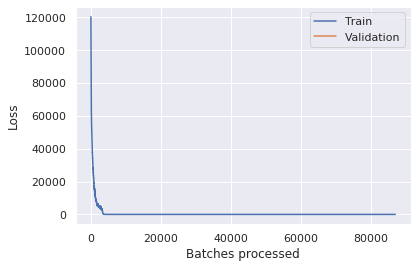

In [29]:
learn.recorder.plot_losses()

In [70]:
preds, _ = learn.get_preds(DatasetType.Test)
# preds[0]

In [102]:
test.shape

torch.Size([30490, 26, 28])

In [114]:
preds = preds.transpose(0,1)
preds.shape

torch.Size([30490, 28, 1])

In [129]:
pred1 = preds.reshape(-1,1,28)

In [158]:
pred2 = pred1.numpy()

In [163]:
pred2 = pd.DataFrame(pred2[:,0,:])

In [165]:
pred1

tensor([[[0.6234, 0.6612, 0.7273,  ..., 1.1068, 1.0985, 1.3072]],

        [[0.4152, 0.4289, 0.4509,  ..., 0.8513, 0.8807, 1.0275]],

        [[0.4257, 0.4395, 0.4639,  ..., 0.8929, 0.9169, 1.0700]],

        ...,

        [[0.3684, 0.3789, 0.3951,  ..., 0.6736, 0.6818, 0.7945]],

        [[0.3680, 0.3784, 0.3946,  ..., 0.6726, 0.6811, 0.7933]],

        [[0.3680, 0.3785, 0.3947,  ..., 0.6729, 0.6814, 0.7938]]])

In [166]:
pred2.columns = ['F' + str(i + 1) for i in range(28)]

In [167]:
pred2

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,0.623414,0.661150,0.727291,0.844749,1.175336,2.244887,4.190627,2.983449,1.186769,0.921041,0.755129,0.722365,0.727448,0.787342,0.954614,1.275204,1.847888,2.444511,2.631334,2.774898,2.514479,1.786237,1.485045,1.241161,1.135060,1.106777,1.098517,1.307183
1,0.415227,0.428938,0.450919,0.485823,0.540963,0.631499,0.822739,0.693114,0.620792,0.591101,0.561286,0.565761,0.601075,0.646951,0.725969,0.842019,1.042516,1.270753,1.173057,1.200494,1.248569,1.106477,1.008054,0.922217,0.864436,0.851295,0.880733,1.027512
2,0.425694,0.439537,0.463925,0.500520,0.561397,0.661232,0.881450,0.727515,0.668773,0.648697,0.640107,0.654346,0.704215,0.699374,0.759133,0.942463,1.160395,1.430371,1.366888,1.286370,1.355720,1.181179,1.067209,0.957700,0.896536,0.892914,0.916852,1.070046
3,0.397591,0.409445,0.428885,0.458858,0.503715,0.578459,0.712647,0.596968,0.529330,0.518528,0.514241,0.518575,0.546732,0.585244,0.642426,0.727386,0.849729,0.991175,1.015816,1.004689,0.993321,0.940182,0.882821,0.821362,0.779121,0.765740,0.777517,0.913377
4,0.375014,0.385576,0.401646,0.426872,0.464270,0.521811,0.619763,0.537110,0.500899,0.480059,0.492557,0.499332,0.523803,0.561244,0.612382,0.687548,0.800392,0.915367,0.940627,0.926207,0.921569,0.881048,0.831627,0.776868,0.743059,0.734023,0.734597,0.865355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0.395719,0.407968,0.427664,0.457392,0.500901,0.572069,0.693237,0.598386,0.555800,0.531447,0.534917,0.542490,0.571301,0.611068,0.657673,0.737185,0.853972,0.939446,0.924426,0.907131,0.887469,0.842596,0.793862,0.744223,0.717760,0.710234,0.714491,0.844771
30486,0.399979,0.412660,0.432906,0.463819,0.509043,0.583641,0.709197,0.612644,0.570888,0.546688,0.539538,0.546249,0.575524,0.607257,0.657819,0.741135,0.860743,0.949209,0.935358,0.917061,0.895593,0.849937,0.800128,0.749011,0.722297,0.714726,0.718725,0.850433
30487,0.368444,0.378882,0.395072,0.419064,0.453787,0.503189,0.587367,0.521276,0.493506,0.490373,0.499937,0.508164,0.534911,0.564322,0.616499,0.689334,0.779189,0.854427,0.836499,0.821169,0.809410,0.776223,0.738266,0.697629,0.677803,0.673561,0.681792,0.794481
30488,0.367989,0.378402,0.394611,0.418501,0.453073,0.502180,0.585326,0.519845,0.492561,0.489497,0.499166,0.507457,0.534070,0.563767,0.616128,0.688982,0.778060,0.852380,0.833731,0.818675,0.806823,0.773768,0.736273,0.695983,0.676687,0.672580,0.681061,0.793304


In [133]:
y1 = [x for a in y for x in a]

In [ ]:
y = pred1.squeeze().tolist()

In [ ]:
y = torch.argmax(preds, dim=1)
y.sum()

In [149]:
INPUT_DIR = "/home/shanmugam/fastai/m5"
submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
        reduce_mem_usage
    )

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [168]:
submission.drop(['F' + str(i + 1) for i in range(28)],axis=1,inplace=True)

In [170]:
final = pd.concat([submission, pred2],axis=1)
# for i in range(1,29):
#     final['F'+str(i)] *= 1.04
final.to_csv('/home/shanmugam/fastai/m5/submission_p2.csv', index = False)

In [180]:
final = final.replace(np.nan,0)
final.to_csv('/home/shanmugam/fastai/m5/submission_p2.csv', index = False)

In [181]:
final

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.623414,0.661150,0.727291,0.844749,1.175336,2.244887,4.190627,2.983449,1.186769,0.921041,0.755129,0.722365,0.727448,0.787342,0.954614,1.275204,1.847888,2.444511,2.631334,2.774898,2.514479,1.786237,1.485045,1.241161,1.135060,1.106777,1.098517,1.307183
1,HOBBIES_1_002_CA_1_validation,0.415227,0.428938,0.450919,0.485823,0.540963,0.631499,0.822739,0.693114,0.620792,0.591101,0.561286,0.565761,0.601075,0.646951,0.725969,0.842019,1.042516,1.270753,1.173057,1.200494,1.248569,1.106477,1.008054,0.922217,0.864436,0.851295,0.880733,1.027512
2,HOBBIES_1_003_CA_1_validation,0.425694,0.439537,0.463925,0.500520,0.561397,0.661232,0.881450,0.727515,0.668773,0.648697,0.640107,0.654346,0.704215,0.699374,0.759133,0.942463,1.160395,1.430371,1.366888,1.286370,1.355720,1.181179,1.067209,0.957700,0.896536,0.892914,0.916852,1.070046
3,HOBBIES_1_004_CA_1_validation,0.397591,0.409445,0.428885,0.458858,0.503715,0.578459,0.712647,0.596968,0.529330,0.518528,0.514241,0.518575,0.546732,0.585244,0.642426,0.727386,0.849729,0.991175,1.015816,1.004689,0.993321,0.940182,0.882821,0.821362,0.779121,0.765740,0.777517,0.913377
4,HOBBIES_1_005_CA_1_validation,0.375014,0.385576,0.401646,0.426872,0.464270,0.521811,0.619763,0.537110,0.500899,0.480059,0.492557,0.499332,0.523803,0.561244,0.612382,0.687548,0.800392,0.915367,0.940627,0.926207,0.921569,0.881048,0.831627,0.776868,0.743059,0.734023,0.734597,0.865355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60976,FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60977,FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,FOODS_3_826_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [113]:
# y = torch.argmax(preds, dim=1)
# y = y[1:]a
# sub = data.iloc[18550276:].copy()
test_df['demand'] = y1
predictions = test_df[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
# for i in range(1,29):
#     final['F'+str(i)] *= 1.04
final.to_csv('/home/shanmugam/fastai/m5/submission_p1.csv', index = False)